In [ ]:
! pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import sktime.datasets

from sktime.datasets import load_from_tsfile
from sklearn import preprocessing
from sktime.classification.deep_learning.lstmfcn import LSTMFCNClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
from tslearn.neighbors import KNeighborsTimeSeries, KNeighborsTimeSeriesClassifier

from sktime.datasets import load_basic_motions
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance


In [ ]:
def label_encoder(training_labels, testing_labels):
    le = preprocessing.LabelEncoder()
    le.fit(np.concatenate((training_labels, testing_labels), axis=0))
    y_train = le.transform(training_labels)
    y_test = le.transform(testing_labels)
    return y_train, y_test


def sliding_window_3d(data, window_size, stride):
    """
    Extracts 3D subsequences from a multivariate time series dataset using a sliding window approach.

    Arguments:
    - data: numpy array of shape (num_timesteps, num_features) representing the time series data.
    - window_size: int representing the length of the sliding window.
    - stride: int representing the stride of the sliding window.

    Returns:
    - numpy array of shape (num_subsequences, num_features, window_size) representing the 3D subsequences.
    """
    num_features, num_timesteps = data.shape
    num_subsequences = ((num_timesteps - window_size) // stride) + 1
    subsequences = np.zeros((num_subsequences, num_features, window_size))
    for j in range(num_subsequences):
        start = j * stride
        end = start + window_size
        subsequences[j] = data[:, start:end]

    return subsequences

def entropy(predict_proba):
    """
    Calculates the entropy of a set of predicted probabilities.

    Args:
        predict_proba (array-like): A 1D array of predicted probabilities.

    Returns:
        float: The entropy of the predicted probabilities.
    """
    predict_proba = predict_proba[np.nonzero(predict_proba)]
    return -np.sum(predict_proba * np.log2(predict_proba))

def native_guide_retrieval(query, target_label, distance, n_neighbors):
    """
    Discover the nearest neighbor from the target class (or we can say NUN from the predict class)

    Args:
        query: the query instance we want to generate cf from
        target_label: the target class of cf
        distance: which disatnce metric we want to use while retriving the NUN
        n_neighbors: the number of neighbors we consider while using K nearest neighbor algorithm
    Returns:
        index: the index of the NUN in the training set
    """
    df = pd.DataFrame(y_train, columns=['label'])
    df.index.name = 'index'
    ts_length = X_train.shape[1] * X_train.shape[2]

    knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric=distance)
    knn.fit(X_train[list(df[df['label'] == target_label].index.values)])

    _, ind = knn.kneighbors(query.reshape(1, query.shape[0], query.shape[1]), return_distance=True)
    return  df[df['label'] == target_label].index[ind[0][:]]



In [ ]:
def target_(instance):
  target = np.argsort((model.predict_proba(instance.reshape(1,instance.shape[0],instance.shape[1]))))[0][-2:-1][0]
  return target

In [ ]:
datasets = ["Epilepsy"]
for name in datasets:
  X_train, y_train = load_from_tsfile("/content/" + name + "_TRAIN.ts", return_data_type="numpy3d")
  X_test, y_test = load_from_tsfile("/content/" + name + "_TEST.ts", return_data_type="numpy3d")

  y_train, y_test = label_encoder(y_train, y_test)

  TS_nums, dim_nums, ts_length = X_train.shape[0], X_train.shape[1], X_train.shape[2]

  model = LSTMFCNClassifier(n_epochs=200, verbose=0)
  model.fit(X_train, y_train)
  y_preds = model.predict(X_test)
  print("Start " + name)
  print("acuu :" + str(model.score(X_test, y_test)))

  min_entropy_indices = []
  cfs = []
  window_size = int(X_test[0].shape[1] * 0.1)
  stride = window_size

  cfs = []
  target_probas = []
  times = []
  for i in range(len(X_test)):  # len(X_test)
      start_time = time.time()
      subsequences = sliding_window_3d(X_test[i], window_size, stride)
      padded_subsequences = np.pad(subsequences, ((0, 0), (0, 0), (0, ts_length - subsequences.shape[2])),
                                     mode='constant')
      predict_proba = model.predict_proba(padded_subsequences)
      pred = model.predict(X_test[i].reshape(1, X_test[i].shape[0], X_test[i].shape[1]))
      entropies = []
      for j in range(len(predict_proba)):
          entro = entropy(predict_proba[j])
          entropies.append(entro)
      indices = np.argsort(entropies)[:10]
       # print(indices)
      min_entropy_index = np.argmin(entropies)
      if pred != y_test[i]:
          target = y_test[i]
      else:
          target = target_(X_test[i])
      idx = native_guide_retrieval(X_test[i], target, 'dtw', 1)

      nun = X_train[idx.item()]
      cf = X_test[i].copy()
      num_dim_changed = []
      k = 1
      for index in indices:
          start = index * stride
          end = start + window_size
          columns_toreplace = list(range(start, end))
          cf[:, columns_toreplace] = nun[:, columns_toreplace]
          cf = cf.reshape(1, cf.shape[0], cf.shape[1])
          if model.predict(cf) == target:
               # print("success")
              # print(k)
              target_proba = model.predict_proba(cf)[0][target]
              target_probas.append(target_proba)
              end = time.time() - start_time
              times.append(end)
              num_dim_changed.append(k)
              cfs.append(cf)
              break
          else:
              cf = cf.reshape(cf.shape[1], cf.shape[2])
              k = k + 1
  # np.save(RES_PATH + name + "_cfs.npy", cfs)
  # np.save(RES_PATH + name + "_times.npy", times)
  # np.save(RES_PATH + name + "_probas.npy", target_probas)
  print(name + ", the avg num of segments have been changed is ")
  print(np.average(num_dim_changed))
  print("finished " + name)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2/2 [==============================] - 1s 46ms/step
Start Epilepsy
2/2 [==============================] - 0s 40ms/step
acuu :0.9782608695652174
1/1 [==============================] - 0s 68ms/step
Epilepsy, the avg num of segments have been changed is 
3.0
finished Epilepsy


# plot the results (compare the original query instances with their counterfactual instances)

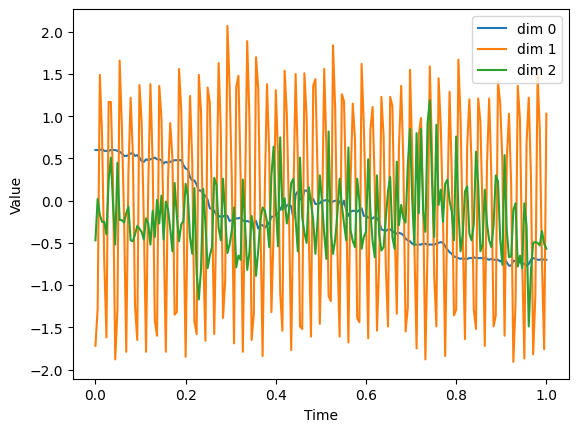

In [ ]:
import matplotlib.pyplot as plt

# Generate some example data
n = X_test.shape[1]  # number of dimensions
t = np.linspace(0, 1, X_test.shape[2])  # time points
data = X_test[0]  # query insatnce from test set

# Plot each dimension as a line with a legend
for i in range(n):
    plt.plot(t, data[i, :], label=f"dim {i}")

# Add axis labels and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# Show the plot
plt.show()

In [ ]:
cfs[0].shape

(1, 3, 206)

In [ ]:
cfs[0] = cfs[0].reshape(cfs[0].shape[1], cfs[0].shape[2])

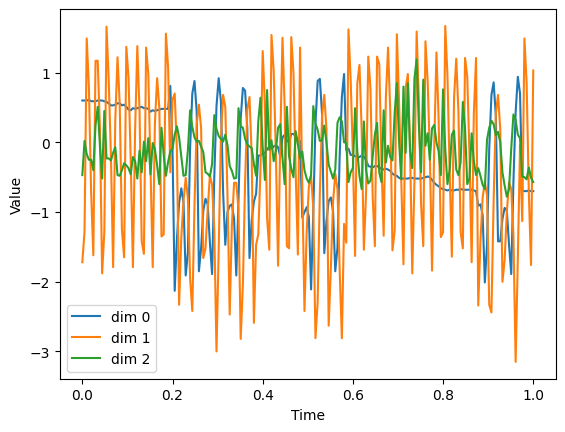

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data
n = X_test.shape[1]  # number of dimensions
t = np.linspace(0, 1, X_test.shape[2])  # time points
data = cfs[0]  # generated cf

# Plot each dimension as a line with a legend
for i in range(n):
    plt.plot(t, data[i, :], label=f"dim {i}")

# Add axis labels and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# Show the plot
plt.show()


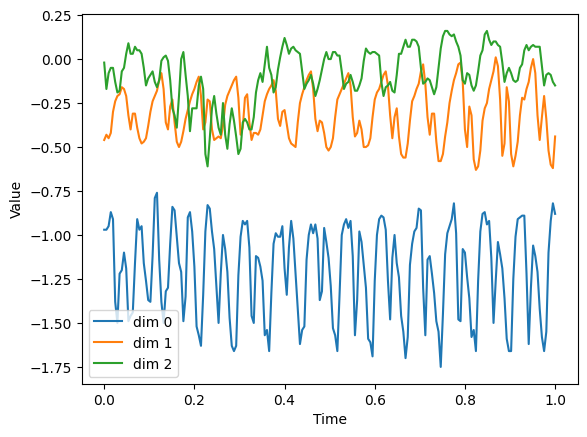

In [ ]:
import matplotlib.pyplot as plt

# Generate some example data
n = X_test.shape[1]  # number of dimensions
t = np.linspace(0, 1, X_test.shape[2])  # time points
data = X_test[50]  # query insatnce from test set

# Plot each dimension as a line with a legend
for i in range(n):
    plt.plot(t, data[i, :], label=f"dim {i}")

# Add axis labels and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# Show the plot
plt.show()

In [ ]:
cfs[50].shape

(1, 3, 206)

In [ ]:
cfs[50] = cfs[50].reshape(cfs[50].shape[1], cfs[50].shape[2])

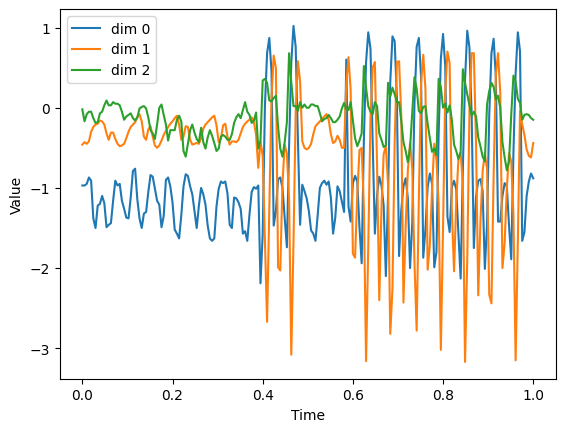

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data
n = X_test.shape[1]  # number of dimensions
t = np.linspace(0, 1, X_test.shape[2])  # time points
data = cfs[50]  # generated cf

# Plot each dimension as a line with a legend
for i in range(n):
    plt.plot(t, data[i, :], label=f"dim {i}")

# Add axis labels and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# Show the plot
plt.show()
